In [2]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np, pandas as pd

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")


%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import NullFormatter
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

# Running selection function

In [3]:
folder = '/home/andy/Documents/Research/SF/SFdata/Galaxia_data/'
iso_folder = '/home/andy/Documents/Research/SF/SFdata/'

In [4]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import StatisticalModels as sm

In [5]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import SelectionGrid, IsochroneScaling, StatisticalModels, SFInstanceClasses

## New selection functions

In [6]:
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
survey['Colour'] = survey.Japp-survey.Kapp

pointings = pd.read_csv(folder + '/Galaxia_sf_fieldinfo.csv')
pointings = pointings[['fieldID', 'glon', 'glat', 'halfangle','Magmin', 'Magmax', 'Colmin', 'Colmax']]
pointings.rename({'glon':'phi', 'glat':'theta'})

def get_photo(field):
    
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

In [32]:
def get_spectro_flat(field):
    
    # Get photometric data
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    # Probability of inclusion
    p = np.zeros(field_data.shape[0]) + 0.1
    p[field_data[:,0]>13.5] = 0.
    p[field_data[:,1]<0.5] = 0.
    survive = np.random.rand(field_data.shape[0])<p
    
    return field_data[survive]

def get_spectro_tanh(field):
    
    # Get photometric data
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    # Probability of inclusion
    p = 0.5 * (1-np.tanh((field_data[:,0]-13.5+0.1)/np.exp(-3)))/2\
            * (1+np.tanh((field_data[:,1]-0.5)/np.exp(-2)))/2\
    
    return field_data

In [28]:
# Get photometric data
file_path = folder + '/photometric/'+str(2.0)+'.csv'
field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
field_data['Colour'] = field_data.Japp - field_data.Kapp
field_data = np.array(field_data[['Happ', 'Colour']])

In [31]:
field_data.shape[0]

8198

In [23]:
pointings = pointings[1:]
pointings.Magmin = 'NoLimit'
pointings.Magmax = 'NoLimit'
pointings.Colmin = 'NoLimit'

In [41]:
SF = SelectionGrid.SFGenerator(get_spectro_tanh, get_photo, pointings, 
                              spectro_model=('BGM_TNC', None), photo_model=('BGM_TNC', None))

The spectro model description is:('BGM_TNC', None)
The photo model description is:('BGM_TNC', None)


In [18]:
%%time
# Load in the isochrone interpolant
IsoCalculator = IsochroneScaling.IntrinsicToObservable()
IsoCalculator.LoadColMag(iso_folder+'isochrones/isochrone_interpolantinstances.pickle')

ImportError: No module named 'dill.dill'

## Generate new selection functions

In [42]:
%%time
SF.gen_obsSF(folder+'/Galaxia_obsSF.pickle')

Creating colour-magnitude field interpolants...
Finished col-mag calculation: 2.0, 1/2, Time: 0.00m, Left: 0.00mN stars =  8198
Running BGM
2   BIC:  -94621.10790119598    lnP:  47364.62382360438
3   BIC:  -96229.61021120811    lnP:  48195.90991511363
4   BIC:  -97916.37268928665    lnP:  49066.3260906561
5   BIC:  -98418.8126879773    lnP:  49344.58102650462
6   BIC:  -99120.30039800408    lnP:  49722.3598180212
7   BIC:  -99412.07877873367    lnP:  49895.28394488919
8   BIC:  -99513.67631846796    lnP:  49973.11765125952
9   BIC:  -99705.65353885666    lnP:  50096.14119795706
10   BIC:  -99722.78665022293    lnP:  50131.742690143394
11   BIC:  -99756.59484750012    lnP:  50175.68172528518
12   BIC:  -99823.14728757464    lnP:  50235.99288182564
13   BIC:  -99811.90556434462    lnP:  50257.406956713814
14   BIC:  -99754.341046253    lnP:  50255.6596341712
Best components:  12
Param shape:  (12, 6)

N stars =  8198
Prior boundaries:  [[-6.69552178  1.17522675]
 [-3.04401824  3.16555064

In [43]:
instsf = SF.obsSF[3.0].SF_model
instdf = SF.obsSF[3.0].DF_model
params_df = instsf.params_df

In [44]:
phot = pd.read_csv('/home/andy/Documents/Research/data/asfe2/Projects/sf_data/Galaxia_data/photometric/3.0.csv')
x = phot.Happ
y = phot.Japp-phot.Kapp
xs = (x-instsf.mux)/instsf.sx
ys = (y-instsf.muy)/instsf.sy

sf_params = instsf.params_f_scaled.copy()
pSelect = StatisticalModels.bivGaussMixture(sf_params, xs, ys)
uncut = (x<13.5)&(y>0.5)
len(instsf.x), np.sum(pSelect), np.sqrt(np.sum(pSelect)), np.sum(pSelect*uncut), np.sqrt(np.sum(pSelect*uncut))

(7964,
 7499.32078517624,
 86.59861884104295,
 1462.4536298783075,
 38.24204008520345)

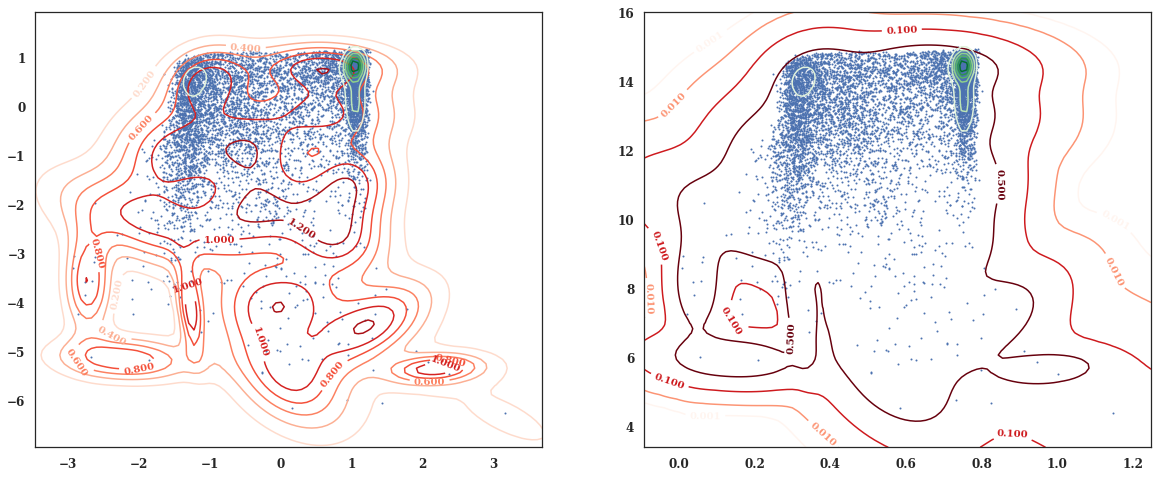

In [45]:
fig, axes = plt.subplots(1,2,figsize=(20,8))

plt.sca(axes[0])
plt.scatter(instsf.y_s, instsf.x_s, s=1)
x = np.linspace(instsf.rngy_s[0], instsf.rngy_s[1], 100)
y = np.linspace(instsf.rngx_s[0], instsf.rngx_s[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f_scaled, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds')
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instsf.params_df, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()

plt.sca(axes[1])
plt.scatter(instsf.y, instsf.x, s=1)
x = np.linspace(instsf.rngy[0], instsf.rngy[1], 100)
y = np.linspace(instsf.rngx[0], instsf.rngx[1], 100)
xx, yy = np.meshgrid(x, y)
zz = StatisticalModels.bivGaussMixture(instsf.params_f, yy, xx)
CS = plt.contour(x, y, zz, cmap='Reds', norm=LogNorm(), levels=(0.001, 0.01, 0.1, 0.5))
plt.clabel(CS, inline=1, fontsize=10)
zz = StatisticalModels.bivGaussMixture(instdf.params_f, yy, xx)
plt.contour(x, y, zz, cmap='Greens')
#plt.colorbar()